In [1]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from numba import jit, float64, guvectorize
import timeit
%matplotlib nbagg

In [2]:
data = np.load('../densitygrid/d10_1200g.npz')
delta10 = data['d10_1200g']
x_coord = delta10.flatten()

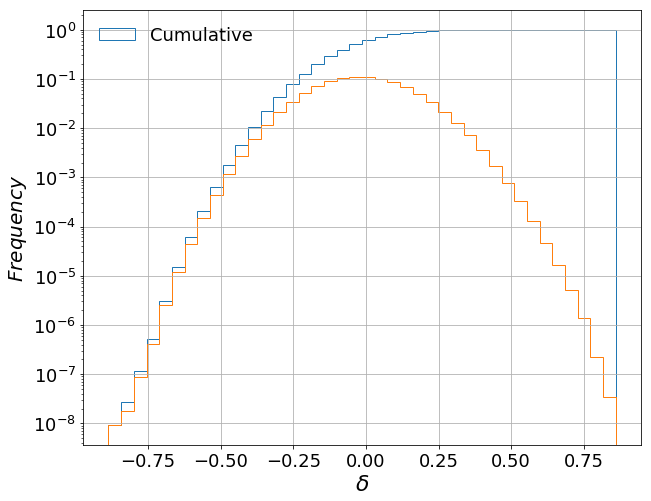

In [3]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10,8), sharex=False, 
                        sharey=False, facecolor='w', edgecolor='k')
weights = np.ones_like(1. + x_coord)/float(len(x_coord))
axs.hist(np.log(1.+x_coord), bins = 40, histtype='step', cumulative=True, label='Cumulative',  weights = weights)
axs.hist(np.log(1.+x_coord), bins = 40, histtype='step',  weights = weights)
axs.set_yscale('log')
axs.grid(True)
axs.legend(loc='upper left', fontsize = 18, frameon = False)
axs.set_xlabel(r'$\delta$', fontsize = 22)
axs.set_ylabel(r'$Frequency$', fontsize = 20)
for label in (axs.get_xticklabels() + axs.get_yticklabels()):
    label.set_fontsize(18)
plt.show()

# Fitting for the lognormal distribution

In [4]:
@jit(float64(float64[:], float64, float64, float64))
def lognormal(x, mean, sig, amp):
    
    return (amp/(x))*np.exp(-((np.log(x)-mean)**2) / (2*sig**2))

@jit(float64[:](float64[:]))
def fitfunction(x_coord):
    
    weights = np.ones_like(1. + x_coord)/float(len(x_coord))

    bins, edges = np.histogram(1. + x_coord, bins = 50, weights = weights)

    left,right = edges[:-1],edges[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([bins,bins]).T.flatten()

    guess = [1.46132049e-02, 0.15, np.mean(Y)]
    popt, pcov = curve_fit(lognormal, (edges[:-1]+edges[1:])/2., bins, p0=guess)
    
    return np.array([popt, pcov.diagonal()])

In [5]:
out = fitfunction(x_coord)
popt, pcov = out
sigma = (np.exp(popt[1]**2) - 1.)*(np.exp(2*popt[0]+popt[1]**2))
print (np.sqrt(sigma))

0.15600930200837512


In [6]:
popt

array([-0.01453883,  0.15544919,  0.10000935])

# Fitting for normal distribution to the log of the data

In [7]:
@jit(float64(float64[:], float64, float64, float64))
def normal(x, mean, sig, amp):
    
    return (amp)*np.exp(-((x-mean)**2) / (2*sig**2))

@jit(float64[:](float64[:]))
def fitfunction(xfit):
    weights = np.ones_like(xfit)/float(len(xfit))

    bins, edges = np.histogram(xfit, bins = 50, weights = weights)

    left,right = edges[:-1],edges[1:]
    X = np.array([left,right]).T.flatten()
    Y = np.array([bins,bins]).T.flatten()

    guess = [1.46132049e-02, 0.15, np.mean(Y)]
    popt, pcov = curve_fit(normal, (edges[:-1]+edges[1:])/2., bins, p0=guess)
    
    return np.array([popt, pcov.diagonal()])

In [8]:
out = fitfunction(np.log(1.+x_coord))
print (out)
popt, pcov = out

[[-1.45829957e-02  1.55670593e-01  8.95134599e-02]
 [ 9.61612724e-08  9.61612631e-08  2.38465047e-08]]


In [9]:
h = 0.6777  #Hubble parameter being used in the simulations
boxsize = 3200*h #Boxsize in h^-1 units
r = np.array([10., 15., 20.]) #Radii used for smoothing
grid = 1200 #The gridsize being used
conv = (boxsize/grid) #Grid lengths in terms of the boxsize 

In [10]:
def near_coords(pos, r):
    
    """
    Gives the coordinates of the points near to the given point inside a a given radius
    coords: in terms of the simuation box coordinates
    pos_coords: array position
    """
    
    a, b, c = pos
    pos_coords = []
    sz = int(max(r)/conv)+1
    
    x = np.arange(a-sz, a+sz+1)
    y = np.arange(b-sz, b+sz+1)
    z = np.arange(c-sz, c+sz+1)
    
    x[x < 0] += grid
    y[y < 0] += grid
    z[z < 0] += grid
    
    x[x >= grid] -= grid
    y[y >= grid] -= grid
    z[z >= grid] -= grid
    
    for i in x: 
        for j in y:
            for k in z:
                pos_coords.append([i, j, k])
    
    pos_coords = np.array(pos_coords)
    
    coords = pos_coords.astype(float)*conv 
    
    return coords, pos_coords

@jit(float64[:,:,:](float64[:,:,:]))
def get_coords(pos):
    
    """
    Given the position of on the density grid it just gives the coordinates in terms of the simualation box
    """
    
    x, y, z = pos
      
    coords = np.zeros((len(x),3))
    
    coords[:,0] = x.astype(float)*conv 
    coords[:,1] = y.astype(float)*conv 
    coords[:,2] = z.astype(float)*conv 
    
    return coords


In [11]:
logcoords = np.log(1. + delta10)
sigma = popt[1]
gc.collect()

15907

# Choosing regions for zoom-in simulations

For selecting the regions I am going to divide the overdensity (1 + $\delta$) in logspace into different $\sigma$ bins. 

In [12]:
#Selecting only regions that do not overlap with each other. Too expensive for low sigma value regions. 
#So instead of checking with these values its better to check if the regions don't overlap with the already
#dresimulated regions.

#Loadin in the regions selected already for resimulation
already_sel = pd.read_table('GEAGLE_regions/GEAGLE_regions.txt', sep='\t', comment='#', index_col=False, 
                            names=['delta', 'x', 'y', 'z'])
print (already_sel)

def get_overlapping_regions(df, selected):
    
    out = pd.DataFrame({'delta': 0., 'x': 0., 'y':0., 'z':0.}, index=[0])
    for i in selected:
        
        sep = np.sum((np.array(df)[:,1:]-i)**2, axis = 1)**0.5
        sel = np.where(sep <= 8.)[0]
           
        tmp = df.iloc[sel]
        tmp = tmp.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
        out = out.append(tmp.iloc[0], ignore_index=True)
            
    return out.iloc[1:]


def remove_overlap_previous(df, prev):
    
    arr = np.array(df)[:,1:]
    
    for this in prev:
        
        sep = np.sum((this-arr)**2, axis = 1)**0.5
        if np.sum(this - prev[0]) == 0.:
            sel = np.where(sep > 10.)[0]
        else:
            sel = np.union1d(sel, np.where(sep > 10.)[0])
        return df.iloc[sel]

       delta          x          y          z
0   1.362403    37.9512   668.6640    45.1800
1   1.315792   843.9624  1443.9528  1062.6336
2   1.299865   802.3968  1337.3280  1086.1272
3   1.287445   618.0624  1140.3432  1525.2768
4   1.254862  1604.7936  1584.9144  1570.4568
5   1.243903   151.8048  1762.0200   534.9312
6   1.231921   459.0288  1212.6312  1409.6160
7   1.230606    59.6376   885.5280  2099.9664
8   1.221547  1049.9832  1785.5136   800.5896
9   1.218040   852.9984   397.5840  2130.6888
10  1.215995  2078.2800  1409.6160   437.3424
11  1.211319   283.7304   867.4560   581.9184
12  1.205913   328.9104   146.3832   684.9288
13  1.200360  1012.0320  1516.2408  1451.1816
14  0.050575   111.8210   248.7160    50.1500
15  0.009954   872.8776  1704.1896   446.3784
16 -0.009918   440.9568   972.2736   766.2528
17 -0.199869   831.3120   390.3552  1093.3560
18 -0.113368   533.1240  1664.4312   914.4432
19  0.169513   122.8896  1736.7192    63.2520
20  0.169366  1895.7528  1368.0504

In [13]:
out = pd.DataFrame({'delta': 0., 'x': 0., 'y':0., 'z':0.}, index=[0])
out

,delta,x,y,z
0,0.0,0.0,0.0,0.0


# $1\sigma - 0.001 \le log(1+\delta) \le 1\sigma + 0.001$ 
Alread done. Rows 19-22 of 'already_sel'

In [14]:
# tmp = np.where(np.logical_and(logcoords >= sigma-0.001, logcoords <= sigma+0.001))
# sigma1_coords = get_coords(tmp)
# print (len(sigma1_coords))
# sigma1_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma1_coords[:,0], 'y': sigma1_coords[:,1], 
#                           'z': sigma1_coords[:,2]}, index = range(len(sigma1_coords)))
# #sigma1_df = sigma1_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# sigma1_df = remove_overlap_previous(sigma1_df, np.array(already_sel)[:,1:])
# gc.collect()

In [15]:
# sel_sigma1 = sigma1_df.sample(n=4)

In [16]:
# sel_sigma1

In [17]:
# out = get_overlapping_regions(sigma1_df, np.array(sel_sigma1)[:,1:])
# out

# $2\sigma-0.001 < log(1+\delta) \le 2\sigma+0.001$ 
Already selected

In [21]:
# tmp = np.where(np.logical_and(logcoords >= 2*sigma-0.001, logcoords <= 2*sigma+0.001))
# sigma1_coords = get_coords(tmp)
# print (len(sigma1_coords))
# sigma2_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma2_coords[:,0], 'y': sigma2_coords[:,1], 
#                           'z': sigma2_coords[:,2]}, index = range(len(sigma2_coords)))
# sigma2_df = remove_overlap_previous(sigma2_df, np.array(already_sel)[:,1:])
# gc.collect()
# sel_sigma2 = sigma2_df.sample(n=6)
# sel_sigma2

In [22]:
# out = get_overlapping_regions(sigma2_df, np.array(sel_sigma2)[:,1:])
# out

# $-2\sigma-0.001 < log(1+\delta) \le -2\sigma+0.001$ 

In [19]:
tmp = np.where(np.logical_and(logcoords >= -2*sigma-0.001, logcoords <= -2*sigma+0.001))
sigma_2_coords = get_coords(tmp)
print (len(sigma_2_coords))
sigma_2_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma_2_coords[:,0], 'y': sigma_2_coords[:,1], 
                          'z': sigma_2_coords[:,2]}, index = range(len(sigma_2_coords)))
sigma_2_df = remove_overlap_previous(sigma_2_df, np.array(already_sel)[:,1:])
gc.collect()
sel_sigma_2 = sigma_2_df.sample(n=6)
sel_sigma_2

1361074


,delta,x,y,z
250084,-0.310722,393.9696,1893.9456,1689.7320
361848,-0.311121,569.2680,370.4760,68.6736
652028,-0.312118,1031.9112,1742.1408,872.8776
525508,-0.311919,829.5048,2040.3288,1199.9808
802800,-0.310722,1270.4616,621.6768,574.6896
65177,-0.310921,101.2032,1608.4080,1863.2232


In [20]:
out = get_overlapping_regions(sigma_2_df, np.array(sel_sigma_2)[:,1:])
out

,delta,x,y,z
1,-0.310722,393.9696,1893.9456,1689.7320
2,-0.310921,569.2680,372.2832,65.0592
3,-0.311121,1031.9112,1742.1408,871.0704
4,-0.311919,829.5048,2040.3288,1199.9808
5,-0.310722,1270.4616,621.6768,574.6896
6,-0.310921,101.2032,1608.4080,1863.2232


# $-2\sigma < log(1+\delta) \le -1\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > -2*sigma, logcoords <= -1*sigma))
# sigma_2_coords = get_coords(tmp)
# print (len(sigma_2_coords))
# sigma_2_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma_2_coords[:,0], 'y': sigma_2_coords[:,1], 
#                           'z': sigma_2_coords[:,2]}, index = range(len(sigma_2_coords)))
# sigma_2_df = sigma_2_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $2\sigma < log(1+\delta) \le 3\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > 2*sigma, logcoords <= 3*sigma))
# sigma3_coords = get_coords(tmp)
# print (len(sigma3_coords))
# sigma3_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma3_coords[:,0], 'y': sigma3_coords[:,1], 
#                           'z': sigma3_coords[:,2]}, index = range(len(sigma3_coords)))
# sigma3_df = sigma3_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $-3\sigma < log(1+\delta) \le -2\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > -3*sigma, logcoords <= -2*sigma))
# sigma_3_coords = get_coords(tmp)
# print (len(sigma_3_coords))
# sigma_3_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma_3_coords[:,0], 'y': sigma_3_coords[:,1], 
#                           'z': sigma_3_coords[:,2]}, index = range(len(sigma_3_coords)))
# sigma_3_df = sigma_3_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $3\sigma < log(1+\delta) \le 4\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > 3*sigma, logcoords <= 4*sigma))
# sigma4_coords = get_coords(tmp)
# print (len(sigma4_coords))
# sigma4_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma4_coords[:,0], 'y': sigma4_coords[:,1], 
#                           'z': sigma4_coords[:,2]}, index = range(len(sigma4_coords)))
# sigma4_df = sigma4_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $-4\sigma < log(1+\delta) \le -3\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > -4*sigma, logcoords <= -3*sigma))
# sigma_4_coords = get_coords(tmp)
# print (len(sigma_4_coords))
# sigma_4_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma_4_coords[:,0], 'y': sigma_4_coords[:,1], 
#                           'z': sigma_4_coords[:,2]}, index = range(len(sigma_4_coords)))
# sigma_4_df = sigma_4_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $4\sigma < log(1+\delta) \le 5\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > 4*sigma, logcoords <= 5*sigma))
# sigma5_coords = get_coords(tmp)
# print (len(sigma5_coords))
# sigma5_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma5_coords[:,0], 'y': sigma5_coords[:,1], 
#                           'z': sigma5_coords[:,2]}, index = range(len(sigma5_coords)))
# sigma5_df = sigma5_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $-5\sigma < log(1+\delta) \le -4\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > -5*sigma, logcoords <= -4*sigma))
# sigma_5_coords = get_coords(tmp)
# print (len(sigma_5_coords))
# sigma_5_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma_5_coords[:,0], 'y': sigma_5_coords[:,1], 
#                           'z': sigma_5_coords[:,2]}, index = range(len(sigma_5_coords)))
# sigma_5_df = sigma_5_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $5\sigma < log(1+\delta) \le 6\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > 5*sigma, logcoords <= 6*sigma))
# sigma6_coords = get_coords(tmp)
# print (len(sigma6_coords))
# sigma6_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma6_coords[:,0], 'y': sigma6_coords[:,1], 
#                           'z': sigma6_coords[:,2]}, index = range(len(sigma6_coords)))
# sigma6_df = sigma6_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()

# $-6\sigma < log(1+\delta) \le -5\sigma$ 

In [ ]:
# tmp = np.where(np.logical_and(logcoords > -6*sigma, logcoords <= -5*sigma))
# sigma_6_coords = get_coords(tmp)
# print (len(sigma_6_coords))
# sigma_6_df = pd.DataFrame({'delta': logcoords[tmp], 'x': sigma_6_coords[:,0], 'y': sigma_6_coords[:,1], 
#                           'z': sigma_6_coords[:,2]}, index = range(len(sigma_6_coords)))
# sigma_6_df = sigma_6_df.sort_values(by=['delta'], ascending=False).reset_index(drop=True)
# gc.collect()